<a href="https://colab.research.google.com/github/Khushboo-30gothwal/python/blob/main/node_classification_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import torch

In [3]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.1+cu121


In [4]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [51]:
!pip install matplotlib

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [62]:
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(10,10))
  plt.xticks([])
  plt.yticks([])

  # plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="set2")
  plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="viridis")
  plt.show()

# **Using GCN -CORA**

**1. Importing CORA - Citation Network Dataset**


In [63]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [64]:
dataset = Planetoid(root='data/Planetoid', name='cora', transform=NormalizeFeatures())

In [65]:
print()
print(f'Dataset: {dataset}:')
print('==========================')
print(f'number of graphs: {len(dataset)}')
print(f'number of features: {dataset.num_features}')
print(f'number of classes: {dataset.num_classes}')


Dataset: cora():
number of graphs: 1
number of features: 1433
number of classes: 7


In [66]:
data = dataset[0] #get the first graph object.

In [67]:
print()
print(data)
print('=====================================================================================================================================')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [68]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'has isolated nods: {data.has_isolated_nodes()}')
print(f'has self-loops: {data.has_self_loops()}')
print(f'is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
training node label rate: 0.05
has isolated nods: False
has self-loops: False
is undirected: True


In [69]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels = 16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# **Model Visulization**

*(untrained GCN)*

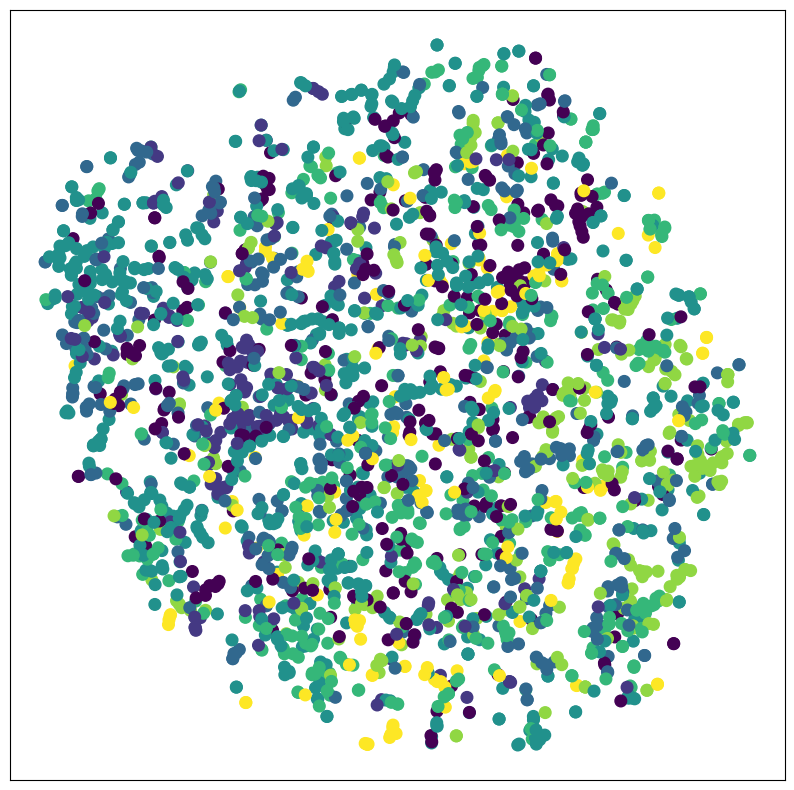

In [70]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# **TRAINING THE GCN**

In [81]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.selfIframeHeight(0, true, {maxHeight:300})'''))

model = GCN(hidden_channels = 16)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad() # clear the gradients
  out = model(data.x, data.edge_index) #perform a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) # compute loss based solely on training nodes
  loss.backward() #derive gradients
  optimizer.step() #update parameters based on gradients
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1) #use the class with the heighest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

for epoch in range(1, 101):
  loss = train()
  print(f'epoch:{epoch:03d}, loss:{loss:.4f}')

<IPython.core.display.Javascript object>

epoch:001, loss:1.9463
epoch:002, loss:1.9409
epoch:003, loss:1.9343
epoch:004, loss:1.9275
epoch:005, loss:1.9181
epoch:006, loss:1.9086
epoch:007, loss:1.9015
epoch:008, loss:1.8933
epoch:009, loss:1.8808
epoch:010, loss:1.8685
epoch:011, loss:1.8598
epoch:012, loss:1.8482
epoch:013, loss:1.8290
epoch:014, loss:1.8233
epoch:015, loss:1.8057
epoch:016, loss:1.7966
epoch:017, loss:1.7825
epoch:018, loss:1.7617
epoch:019, loss:1.7491
epoch:020, loss:1.7310
epoch:021, loss:1.7147
epoch:022, loss:1.7056
epoch:023, loss:1.6954
epoch:024, loss:1.6697
epoch:025, loss:1.6538
epoch:026, loss:1.6312
epoch:027, loss:1.6161
epoch:028, loss:1.5899
epoch:029, loss:1.5711
epoch:030, loss:1.5576
epoch:031, loss:1.5393
epoch:032, loss:1.5137
epoch:033, loss:1.4948
epoch:034, loss:1.4913
epoch:035, loss:1.4698
epoch:036, loss:1.3998
epoch:037, loss:1.4041
epoch:038, loss:1.3761
epoch:039, loss:1.3631
epoch:040, loss:1.3258
epoch:041, loss:1.3030
epoch:042, loss:1.3119
epoch:043, loss:1.2519
epoch:044, 

In [82]:
test_acc = test()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.8150


# **Model Visualization**

*(trained GCN)*

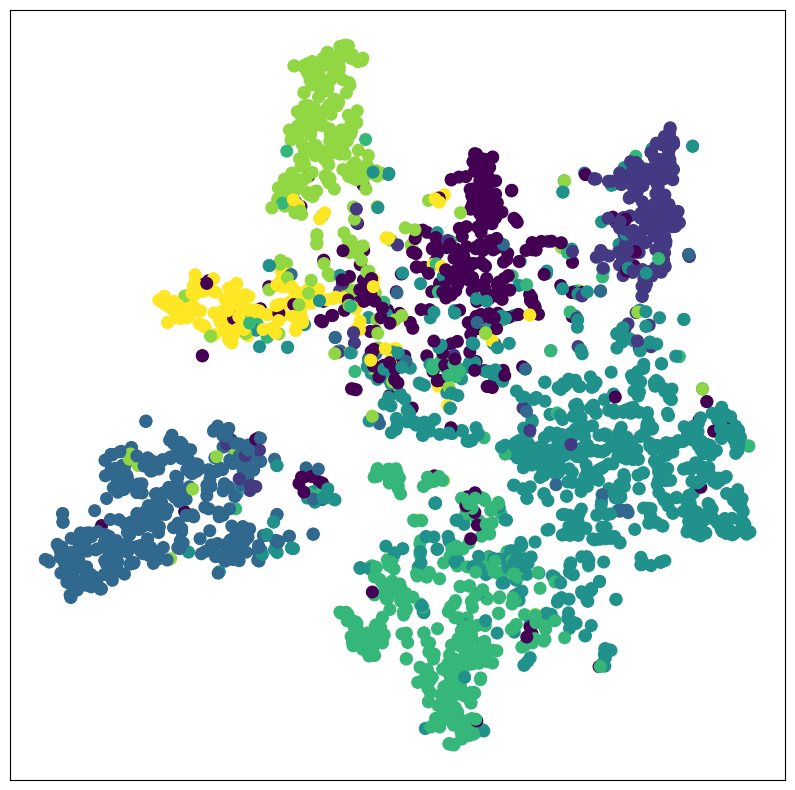

In [85]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color = data.y)